## Inspiration
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way.I want to use a dateset from Airbnb to help people make decision when traveling to Seattle.

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
pd.set_option('display.max_columns',None)

In [54]:
cal = pd.read_csv('seattle/calendar.csv')
listing = pd.read_csv('seattle/listings.csv')
reviews = pd.read_csv('seattle/reviews.csv')

## When is the busiest time of the year in Seattle?

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


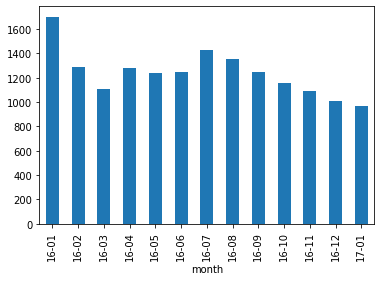

In [61]:
# get all the room which is ordered
ordered = cal[cal['available'] == 'f']

# create month column
ordered['month'] =  ordered['date'].apply(lambda m:m[2:7])

# groupby month, count the num of order for each month
ordered_cnt = ocu.groupby(['month']).count()['listing_id']

# count how many day in a month
date = set(ocu['date'])
df = pd.DataFrame(date)
df['month'] = df[0].apply(lambda m:m[2:7])
days = df.groupby('month').count().loc[:,0]

# compute the average number of orders in a month
avg_cnt = ord_cnt/days

# oberseve the distribute of orders
avg_cnt.plot(kind='bar')

# There are more orders in summer

## What factors are house prices related to 

In [228]:
def clean_and_code(X):
    # reduce the num of category
    X['host_since'] = X['host_since'].apply(lambda y:y[:4])
    X['first_review'] = X['first_review'].apply(lambda y:y[:4])
    
    neig = X['neighbourhood'].value_counts()
    major_neig=neig[neig>8].keys()
    X['neighbourhood'] = X['neighbourhood'].apply(lambda m  : m if (m in major_neig) else 'Other')

    pro_type = X['property_type'].value_counts()
    major_pro=pro_type[pro_type>8].keys()
    X['property_type'] = X['property_type'].apply(lambda m  : m if (m in major_pro) else 'Other')

    # encode category data
    cat_cols = X.select_dtypes(include=['object']).copy().columns
    for col in cat_cols:
        X = pd.concat([X.drop(col,axis=1),pd.get_dummies(X[col],prefix=col,drop_first=True)],axis=1)
    return X

In [237]:

# gather data 
feat=['host_since','host_response_time','host_is_superhost','neighbourhood','is_location_exact','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','availability_365','number_of_reviews','first_review','num_price']
sub = listing[feat]
sub = sub.dropna(axis=0)
# get response vector and feature matrix
y = sub['num_price']
X = sub.drop(['num_price'],axis=1)

# clean data 
X = clean_and_code(X)
# split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# init model 
model = LinearRegression(normalize=True)
model.fit(X_train,y_train)

# test model
y_pred = model.predict(X_test)
r2_score(y_test,y_pred)

0.5581798915148795

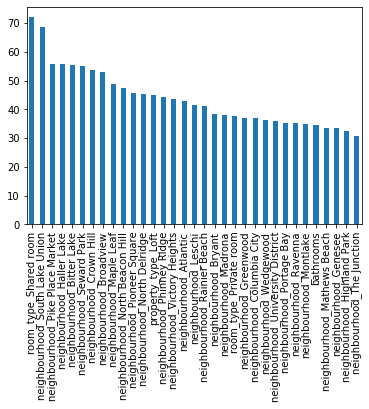

In [238]:
s=pd.Series(abs(model.coef_),index=X.columns)
s = s[s>30]
s.sort_values(ascending=False).plot(kind='bar')

In [220]:
s.sort_values(ascending=False)

room_type_Shared room                72.016931
neighbourhood_South Lake Union       68.543045
neighbourhood_Pike Place Market      55.891655
neighbourhood_Haller Lake            55.668513
neighbourhood_Bitter Lake            55.279858
neighbourhood_Seward Park            54.925690
neighbourhood_Crown Hill             53.658942
neighbourhood_Broadview              53.058219
neighbourhood_Maple Leaf             48.839446
neighbourhood_North Beacon Hill      47.322156
neighbourhood_Pioneer Square         45.543056
neighbourhood_North Delridge         45.312352
property_type_Loft                   44.964130
neighbourhood_Phinney Ridge          44.184286
neighbourhood_Victory Heights        43.717344
neighbourhood_Atlantic               42.980941
neighbourhood_Leschi                 41.381513
neighbourhood_Rainier Beach          41.139064
neighbourhood_Bryant                 38.244444
neighbourhood_Madrona                37.921966
room_type_Private room               37.586344
neighbourhood

## Where can we find cheap house？

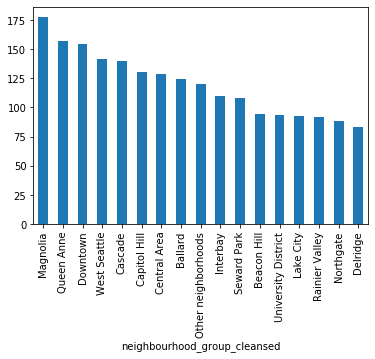

In [224]:
# Convert the type of price to float 
listing['num_price'] = listing['price'].apply(lambda p:float(p[1:].replace(',','')))

# Compute the average price for each neighbourhood
prices = listing.groupby('neighbourhood_group_cleansed').mean()['num_price']
prices.sort_values(ascending=False).plot(kind='bar')
# house in MAGNOLIA is most experience